In [1]:

import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.iloc[2]['comment_text']

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

## Preprocess

In [7]:
!pip list

Package                           Version
--------------------------------- ---------------
absl-py                           2.0.0
aiofiles                          22.1.0
albumentations                    1.3.1
altair                            5.0.1
annotated-types                   0.6.0
anyio                             4.2.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.4.1
astunparse                        1.6.3
async-lru                         2.0.4
attrs                             23.2.0
autoviz                           0.1.806
Babel                             2.14.0
beautifulsoup4                    4.12.2
bleach                            6.1.0
bokeh                             2.4.3
Bottleneck                        1.3.5
Brotli                            1.0.9
cached-property                   1.5.2
cachetools                        5.3.2
certifi             

In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
from tensorflow.keras.layers import TextVectorization

In [12]:
x=df["comment_text"]
y=df[df.columns[2:]].values

In [13]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [14]:
x

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [16]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [18]:
MAX_FEATURES=20000

In [20]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [21]:
vectorizer.adapt(x.values)

In [22]:
vectorized_text=vectorizer(x.values)

In [24]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[ 643,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2506, ...,    0,    0,    0],
       [ 425,  440,   70, ...,    0,    0,    0],
       ...,
       [   1, 7329,  383, ...,    0,    0,    0],
       [   5,   12,  533, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]], dtype=int64)>

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [28]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Sequence Model Architecture

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [31]:
model = Sequential()
#  embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
#  Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [32]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [35]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 1240s 177ms/step - loss: 0.0628 - val_loss: 0.0480
Epoch 2/10
6981/6981 [==============================] - 1322s 189ms/step - loss: 0.0483 - val_loss: 0.0441
Epoch 3/10
6981/6981 [==============================] - 1252s 179ms/step - loss: 0.0444 - val_loss: 0.0424
Epoch 4/10
6981/6981 [==============================] - 1206s 173ms/step - loss: 0.0412 - val_loss: 0.0370
Epoch 5/10
6981/6981 [==============================] - 1321s 189ms/step - loss: 0.0379 - val_loss: 0.0339
Epoch 6/10
6981/6981 [==============================] - 1183s 169ms/step - loss: 0.0355 - val_loss: 0.0316
Epoch 7/10
6981/6981 [==============================] - 1438s 206ms/step - loss: 0.0330 - val_loss: 0.0293
Epoch 8/10
6981/6981 [==============================] - 1161s 166ms/step - loss: 0.0307 - val_loss: 0.0285
Epoch 9/10
6981/6981 [==============================] - 1204s 172ms/step - loss: 0.0291 - val_loss: 0.0259
Epoch 10/10
6981/6981 [==============

In [36]:
history.history

{'loss': [0.06278979033231735,
  0.04830821231007576,
  0.04440246522426605,
  0.04121015593409538,
  0.03785306587815285,
  0.03552129864692688,
  0.03299447149038315,
  0.030697394162416458,
  0.02911706268787384,
  0.026411259546875954],
 'val_loss': [0.048018988221883774,
  0.04406905546784401,
  0.042407866567373276,
  0.03697800636291504,
  0.03387845680117607,
  0.031604524701833725,
  0.0292844045907259,
  0.02852766588330269,
  0.025872504338622093,
  0.023609673604369164]}

In [37]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

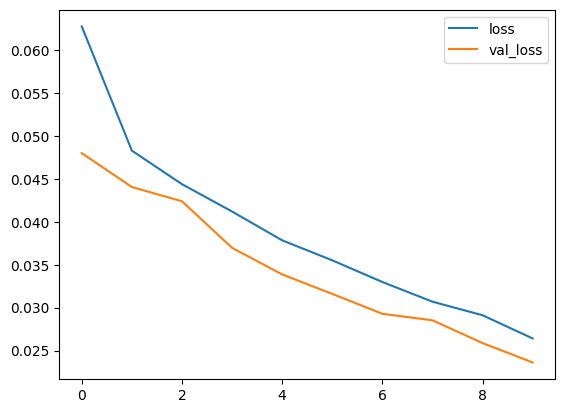

In [38]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Predictions

In [40]:
input_text = vectorizer('You freaking suck! I am going to bit you.')

In [41]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7113,  396, ...,    0,    0,    0], dtype=int64)>

In [42]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [43]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 569ms/step


array([[0.99719256, 0.08500203, 0.95627314, 0.00187306, 0.95939726,
        0.03799162]], dtype=float32)

In [44]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [45]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 177ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [46]:
res=model.predict(batch_X)

1/1 [==============================] - 0s 172ms/step


In [47]:
res.shape

(16, 6)

## Evaluate

In [48]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [49]:
pre=Precision()
re=Recall()
ca=CategoricalAccuracy()

In [50]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    ca.update_state(y_true, yhat)

1/1 [==============================] - 0s 105ms/step


In [52]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{ca.result().numpy()}')

Precision: 0.8819800615310669, Recall:0.8543859720230103, Accuracy:0.47442325949668884


## Test 

In [53]:
import gradio as gr

In [56]:
model.save('toxicity.h5')

In [57]:
import tensorflow as tf
import numpy as np

In [58]:
input_text = vectorizer('hey i freaken hate you!')

In [64]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [66]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder="Comment here"),
                        outputs='text')

In [67]:
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 151ms/step
